In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import kurtosis, skew
from scipy import stats


## Load files with evaluated training

In [ ]:
import pandas as pd
import os
# Create a nested dictionary tau-->seed
tau_levels = [0.1,0.5,0.9]
tau_levels_str = [str(tau).replace('.', '') for tau in tau_levels]
seed_list = [53,1234,89,274] 

base_path = "C:/Users/95att/Desktop/job/First_paper_QAC/QAC-Final/QAC-Final/StepWise Learning/StepWiseModel/training_outcome/"
dfs = {}

for tau_str in tau_levels_str:
    dfs[tau_str] = {}
    for seed in seed_list:
        folder_name = f"RUN_2025-05-22_gauss_weighted_quantile_stepwise_standard_tanh_{seed}_{tau_str}"
        file_path = os.path.join(base_path, folder_name, "train_df_with_shares.csv")

        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            dfs[tau_str][seed] = df
        else:
            print(f" File not found: {file_path}")


In [5]:
# For training outcome: Value function, TD error etc
tau_levels = [0.1,0.5,0.9]
tau_levels_str = [str(tau).replace('.', '') for tau in tau_levels]
seed_list = [53,1234,89,274] 

base_path = "C:/Users/95att/Desktop/job/First_paper_QAC/QAC-Final/QAC-Final/StepWise Learning/StepWiseModel/training_outcome/"
dfs_metrics = {}

for tau_str in tau_levels_str:
    dfs_metrics[tau_str] = {}
    for seed in seed_list:
        folder_name = f"RUN_2025-05-18_gauss_weighted_quantile_stepwise_final_tanh_{seed}_{tau_str}"
        file_path = os.path.join(base_path, folder_name, "metrics.pkl")

        if os.path.exists(file_path):
            df = pd.read_pickle(file_path)
            dfs_metrics[tau_str][seed] = df
        else:
            print(f" File not found: {file_path}")

In [5]:
for tau_str, seed_dict in dfs.items():
    for seed, df in seed_dict.items():
        print(f"tau: {tau_str}, seed: {seed}, df shape: {df.shape}")


tau: 01, seed: 53, df shape: (1422, 19)
tau: 01, seed: 1234, df shape: (1422, 19)
tau: 01, seed: 89, df shape: (1422, 19)
tau: 01, seed: 274, df shape: (1422, 19)
tau: 05, seed: 53, df shape: (1422, 19)
tau: 05, seed: 1234, df shape: (1422, 19)
tau: 05, seed: 89, df shape: (1422, 19)
tau: 05, seed: 274, df shape: (1422, 19)
tau: 09, seed: 53, df shape: (1422, 19)
tau: 09, seed: 1234, df shape: (1422, 19)
tau: 09, seed: 89, df shape: (1422, 19)
tau: 09, seed: 274, df shape: (1422, 19)


In [7]:
#  data validity check

def validate_dfs_date_alignment(dfs):
    for tau_str, seed_dict in dfs.items():
        print(f"\nChecking tau = {tau_str}...")
        reference_dates = None
        reference_length = None

        for seed, df in seed_dict.items():
            if 'date' not in df.columns:
                print(f"  Seed {seed}: Missing 'date' column.")
                continue

            df['date'] = pd.to_datetime(df['date'])
            df = df.sort_values('date')  # Ensure consistent order

            date_values = df['date'].values
            num_rows = len(date_values)

            if reference_dates is None:
                reference_dates = date_values
                reference_length = num_rows
                print(f"  Seed {seed}: Set as reference with {num_rows} rows.")
            else:
                if num_rows != reference_length:
                    print(f"  Seed {seed}: Row count mismatch ({num_rows} vs {reference_length})")

                if not np.array_equal(date_values, reference_dates):
                    print(f"  Seed {seed}: Dates do not match reference.")
                else:
                    print(f"  Seed {seed}: Dates match reference.")

    print("\nValidation complete.")


In [9]:
validate_dfs_date_alignment(dfs)



Checking tau = 01...
  Seed 53: Set as reference with 1422 rows.
  Seed 1234: Dates match reference.
  Seed 89: Dates match reference.
  Seed 274: Dates match reference.

Checking tau = 05...
  Seed 53: Set as reference with 1422 rows.
  Seed 1234: Dates match reference.
  Seed 89: Dates match reference.
  Seed 274: Dates match reference.

Checking tau = 09...
  Seed 53: Set as reference with 1422 rows.
  Seed 1234: Dates match reference.
  Seed 89: Dates match reference.
  Seed 274: Dates match reference.

Validation complete.


## Value functions

In [11]:
#  tau_to_dfs[tau] = [df1, df2, df3]
tau_to_dfs = {}
for tau, seed_dict in dfs.items():
    for seed, df in seed_dict.items():
        tau_to_dfs.setdefault(tau, []).append(df)

tau_avg_paths = {}
for tau, df_list in tau_to_dfs.items():
    v_columns = [col for col in df_list[0].columns if col.startswith('v_')] # same columns shape
    stacked = np.stack([df[v_columns].values for df in df_list]) # n_seeds, n_steps, n_v_columns
    avg_path = np.mean(stacked, axis=0) # (n_steps, n_v_columns)
    tau_avg_paths[tau] = pd.DataFrame(avg_path, columns=v_columns)

result = pd.DataFrame({
    f"tau_{tau}": df.mean()  
    for tau, df in tau_avg_paths.items()
}).T

result.columns = [f"mean_{col}" for col in result.columns]
result

,mean_v_01,mean_v_02,mean_v_03,mean_v_04,mean_v_05,mean_v_06,mean_v_07,mean_v_08,mean_v_09
tau_01,-10.727364,-4.700312,-2.722897,0.221648,0.920818,2.364448,4.677116,7.886615,10.878593
tau_05,-13.752519,-6.380828,-3.874322,0.312823,1.286180,3.109440,6.046906,10.158027,13.619101
tau_09,-14.441594,-6.370241,-3.776443,0.178266,0.948865,2.565667,6.176145,10.687034,14.734264


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

def plot_combined_kde_with_stats(dfs, tau_levels_str):
    plt.figure(figsize=(10, 6))
    stats_list = []  

    for tau_str in tau_levels_str:
        # Gather all v_ columns across seeds for this tau
        all_values = []
        for seed, df in dfs[tau_str].items():
            v_cols = [col for col in df.columns if col.startswith('v_')]
            all_values.append(df[v_cols].values.flatten())
        
        # Combine all values across seeds
        combined_values = np.concatenate(all_values)
        
        # Compute stats
        mean_val = np.mean(combined_values)
        std_val = np.std(combined_values)
        skew_val = skew(combined_values)
        kurt_val = kurtosis(combined_values)
        stats_list.append([f'tau_{tau_str}', mean_val, std_val, skew_val, kurt_val])
        
        sns.kdeplot(combined_values, label=f'tau_{tau_str}', shade=True)

    plt.title("Combined KDE of Estimated Quantiles Across Seeds")
    plt.xlabel("Estimated Quantile Value")
    plt.ylabel("Density")
    plt.legend(title="Policy")

    stats_df = pd.DataFrame(stats_list, columns=['Policy', 'Mean', 'Std', 'Skewness', 'Kurtosis'])
    stats_text = stats_df.to_string(index=False, float_format=lambda x: f"{x:.2f}")

    ax = plt.gca()
    ax.text(0.02, 0.5, stats_text,
            fontsize=12, family="monospace",
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.tight_layout()
    plt.savefig('combined_kdes_gauss_stepwise.png', dpi=300)

    plt.show()


In [15]:
def plot_individual_quantile_kdes(dfs, tau1_str, tau2_str):

    df1 = dfs[tau1_str]
    df2 = dfs[tau2_str]
    
    quantile_cols = [col for col in df1.columns if col.startswith('v_')]
    n_quantiles = len(quantile_cols)
    
    ncols = 3
    nrows = int(np.ceil(n_quantiles / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
    axs = axs.flatten() 
    
    for i, col in enumerate(quantile_cols):
        ax = axs[i]
        
        data1 = df1[col].dropna().values
        data2 = df2[col].dropna().values
        
        sns.kdeplot(data1, ax=ax, label=f'tau_{tau1_str}', shade=True)
        sns.kdeplot(data2, ax=ax, label=f'tau_{tau2_str}', shade=True)
        
        ax.set_title(f"KDE for {col}")
        ax.set_xlabel("Estimated Quantile Value")
        ax.set_ylabel("Density")
        
        mean1 = np.mean(data1)
        var1  = np.var(data1)
        skew1 = stats.skew(data1)
        kurt1 = stats.kurtosis(data1)
        
        mean2 = np.mean(data2)
        var2  = np.var(data2)
        skew2 = stats.skew(data2)
        kurt2 = stats.kurtosis(data2)
        
        textstr = (f"tau_{tau1_str}:\nMean: {mean1:.2f}\nVar: {var1:.2f}\n"
                   f"Skew: {skew1:.2f}\nKurt: {kurt1:.2f}\n\n"
                   f"tau_{tau2_str}:\nMean: {mean2:.2f}\nVar: {var2:.2f}\n"
                   f"Skew: {skew2:.2f}\nKurt: {kurt2:.2f}")
        
        # Place the statistics text box in the top left corner of the subplot.
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        
        ax.legend()
    
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.savefig('individual_kdes_gauss_stepwise.png', dpi=300)

    plt.show()

C:\Users\95att\AppData\Local\Temp\ipykernel_42216\1633588853.py:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(combined_values, label=f'tau_{tau_str}', shade=True)
C:\Users\95att\AppData\Local\Temp\ipykernel_42216\1633588853.py:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(combined_values, label=f'tau_{tau_str}', shade=True)
C:\Users\95att\AppData\Local\Temp\ipykernel_42216\1633588853.py:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(combined_values, label=f'tau_{tau_str}', shade=True)


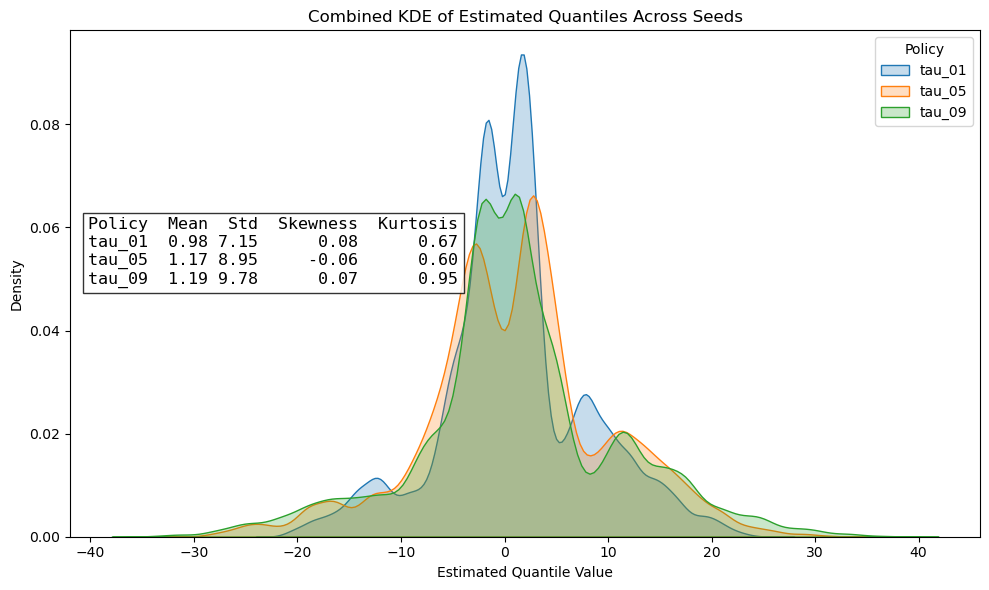

In [17]:
 plot_combined_kde_with_stats(dfs, tau_levels_str)

## What do we expect? Let's compare tau 1 and 3
- Tau_1 should be shifted left because it is trained to optimize for a lower quantile of the return distribution
- lower std
- tau 1 should be right sweked more because it is optimized for lower returns but has a small probability of achieving higher values.
- higher kurtosis

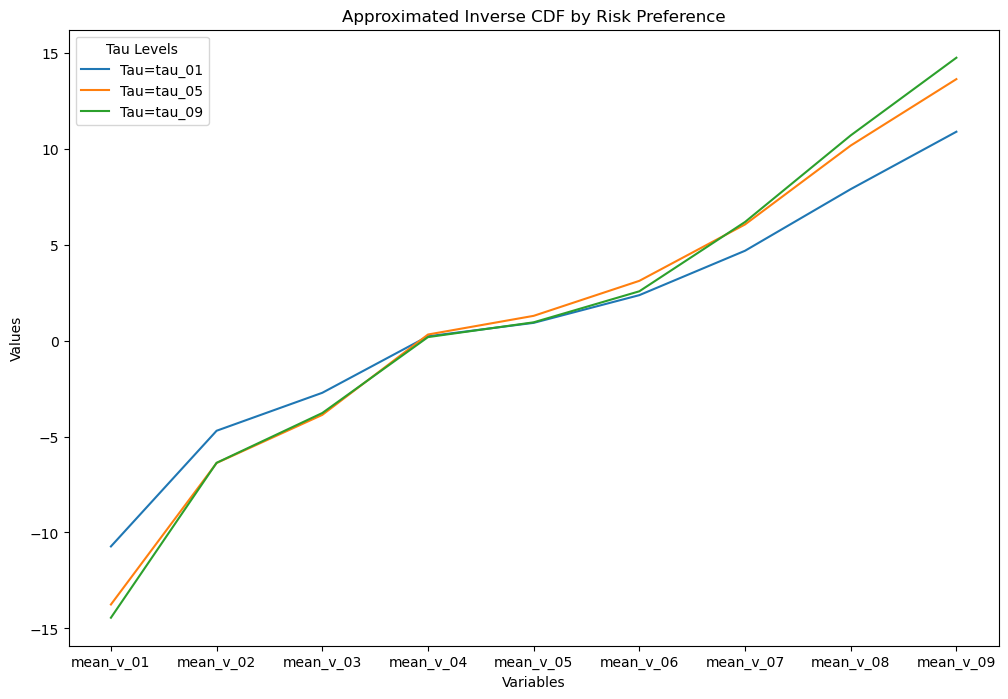

In [19]:
result.reset_index(inplace=True)
result.rename(columns={"index": "tau"}, inplace=True)

# Plotting
plt.figure(figsize=(12, 8))

# Loop through each row in the DataFrame
for index, row in result.iterrows():
    tau_label = row['tau']  
    plt.plot(result.columns[1:], row[1:], label=f"Tau={tau_label}")

plt.xlabel('Variables')
plt.ylabel('Values')
plt.title('Approximated Inverse CDF by Risk Preference')
plt.legend(title="Tau Levels")
plt.savefig('inverse_cdf_gauss_stepwise.png', dpi=300)

plt.show()


In [21]:
plot_individual_quantile_kdes(dfs,'05', '07')

AttributeError: 'dict' object has no attribute 'columns'

## What do we expect?
- Each policy is optimized to get the highest discounted value in a specific quantile
- for tau 1 we should get higher mean and lower std for v1
- for tau 7 higher values v7 and lower std
- for higher v-s lower taus are more compressed

## Absolute return distribution

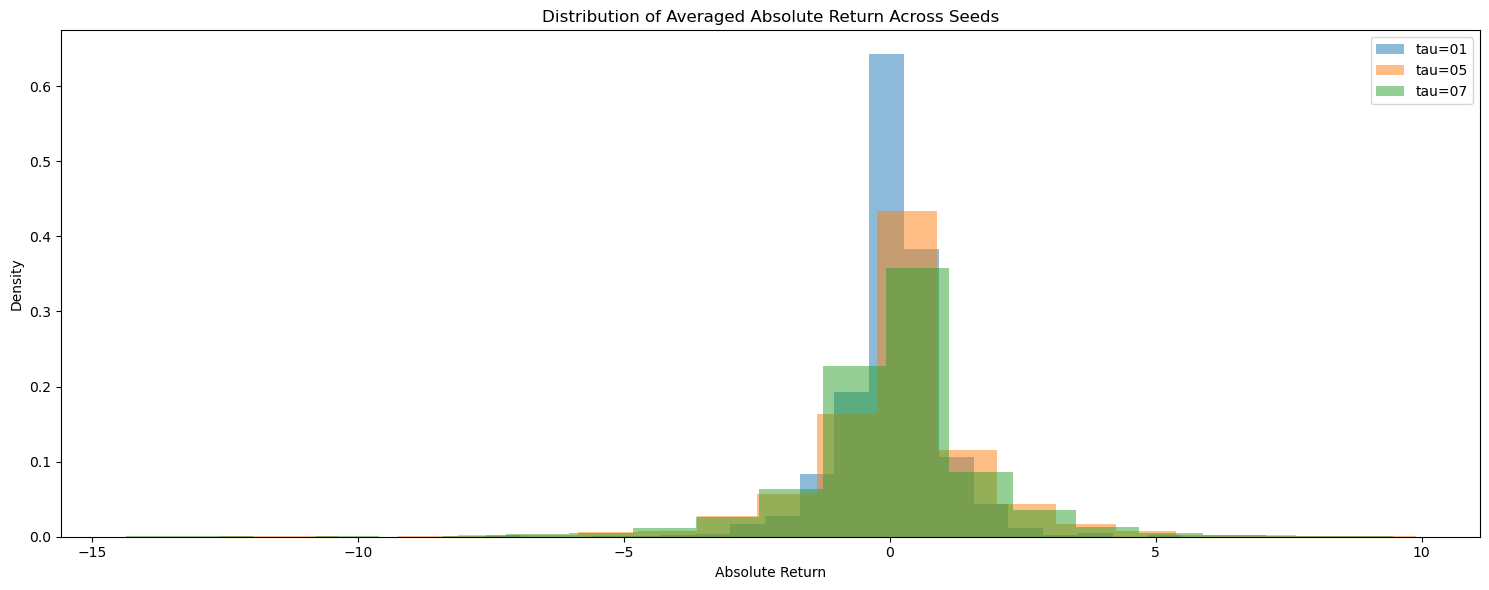

In [232]:
tau_to_abs_returns = {}

for tau_str, seed_dict in dfs.items():
    abs_returns = []
    for seed, df in seed_dict.items():
        if 'absolute_return' in df.columns:
            abs_returns.append(df['absolute_return'].values)

    if abs_returns:
        min_len = min(map(len, abs_returns))
        trimmed = [arr[:min_len] for arr in abs_returns]
        avg_abs_return = np.mean(trimmed, axis=0)
        tau_to_abs_returns[tau_str] = avg_abs_return

# Plot histogram of averaged absolute returns
plt.figure(figsize=(15, 6))
for tau_str, avg_abs in tau_to_abs_returns.items():
    plt.hist(avg_abs, bins=20, alpha=0.5, label=f"tau={tau_str}", density=True)

plt.xlabel('Absolute Return')
plt.ylabel('Density')
plt.title('Distribution of Averaged Absolute Return Across Seeds')
plt.legend()
plt.tight_layout()
plt.show()

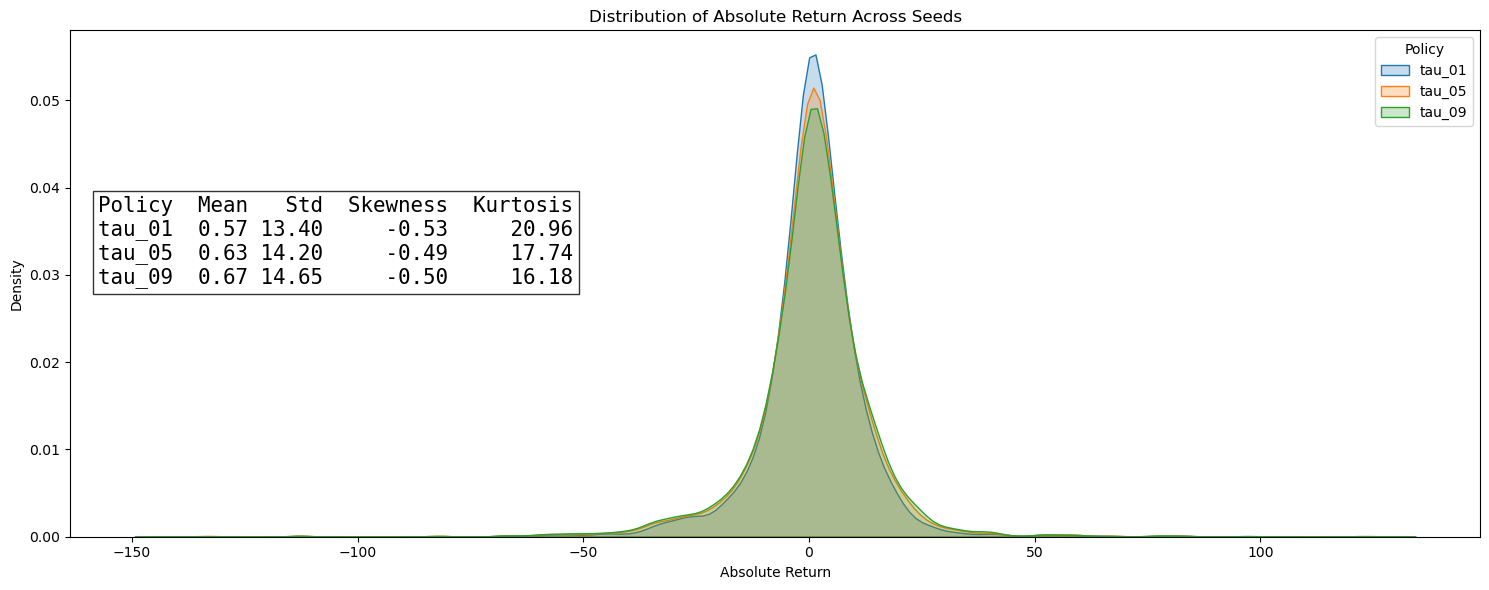

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

plt.figure(figsize=(15, 6))

stats_list = []

for tau_str in tau_levels_str:
    absolute_returns = []

    for seed, df in dfs[tau_str].items():
        if 'absolute_return' in df.columns:
            absolute_returns.append(df['absolute_return'].values)

    if absolute_returns:
        combined = np.concatenate(absolute_returns)
        sns.kdeplot(combined, label=f'tau_{tau_str}', fill=True)

        # Compute stats
        mean_val = np.mean(combined)
        std_val = np.std(combined)
        skew_val = skew(combined)
        kurt_val = kurtosis(combined)
        stats_list.append([f'tau_{tau_str}', mean_val, std_val, skew_val, kurt_val])

# Add axis labels and title
plt.xlabel('Absolute Return')
plt.ylabel('Density')
plt.title('Distribution of Absolute Return Across Seeds')
plt.legend(title='Policy')

# Add table of statistics
stats_df = pd.DataFrame(stats_list, columns=['Policy', 'Mean', 'Std', 'Skewness', 'Kurtosis'])
stats_text = stats_df.to_string(index=False, float_format=lambda x: f"{x:.2f}")

ax = plt.gca()
ax.text(
    0.02, 0.5, stats_text,
    fontsize=15, family="monospace",
    transform=ax.transAxes,
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
)

plt.tight_layout()
plt.savefig("absolute_return_distribution_stats_stepwise.png", dpi=300, bbox_inches='tight')
plt.show()


## Cumulative reward comparison

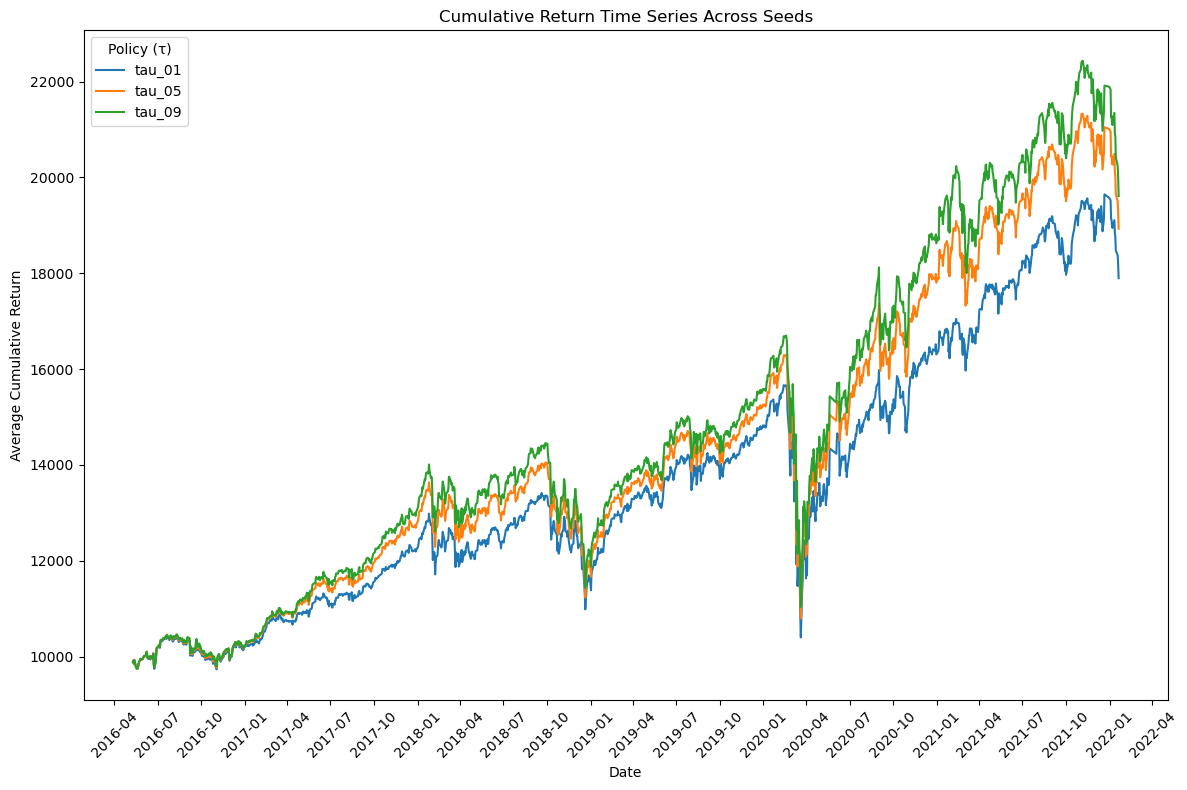

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

plt.figure(figsize=(12, 8))
ax = plt.gca()

for tau_str in dfs:
    cum_returns_list = []
    date_index = None

    for seed, df in dfs[tau_str].items():
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')
        if date_index is None:
            date_index = df['date'].values
        cum_returns_list.append(df['cumulative_return'].values)

    avg_cum_return = np.mean(np.stack(cum_returns_list), axis=0)
    plt.plot(date_index, avg_cum_return, label=f'tau_{tau_str}')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))     
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))    

plt.xlabel('Date')
plt.ylabel('Average Cumulative Return')
plt.title('Cumulative Return Time Series Across Seeds')
plt.legend(title='Policy (τ)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("avg_cumulative_returns_stepwise.png", dpi=300, bbox_inches='tight')
plt.show()


# Average plot for shares

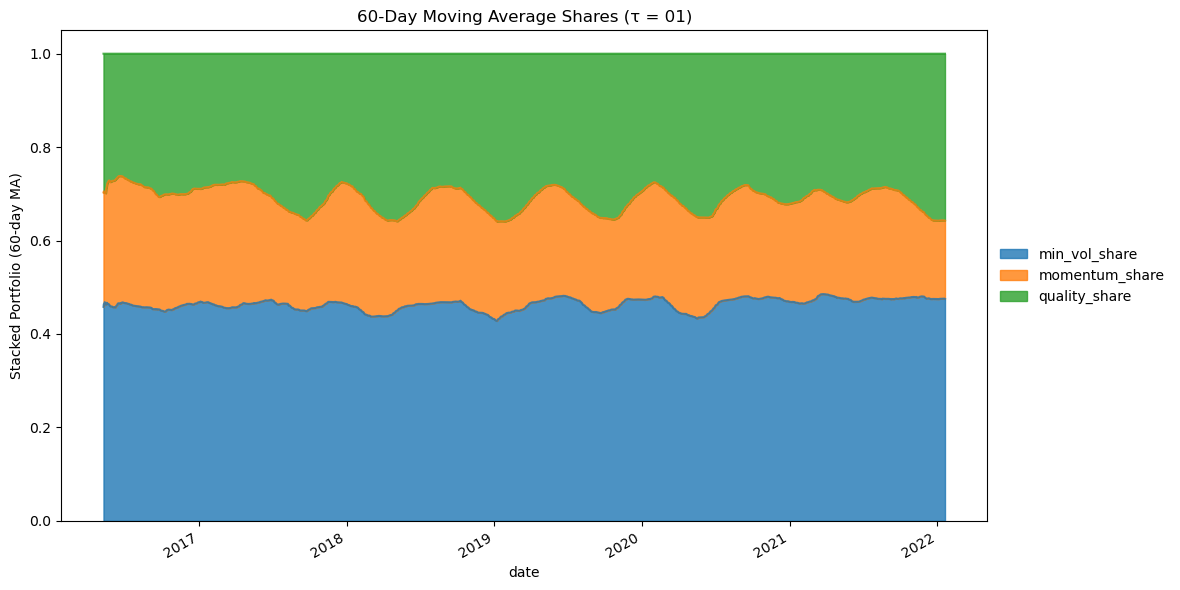

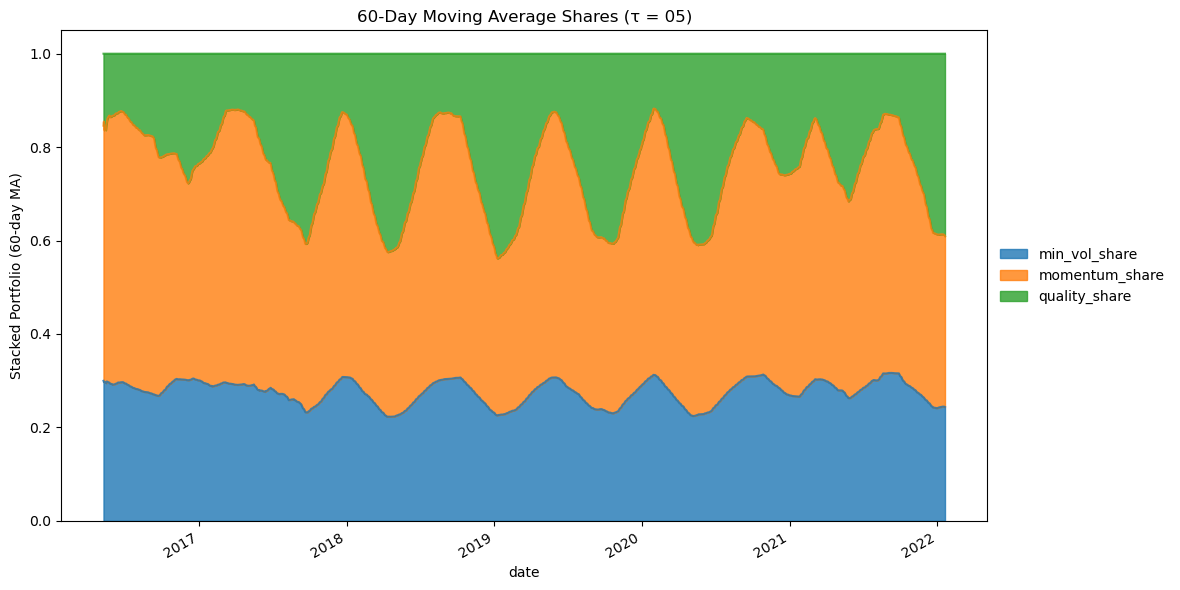

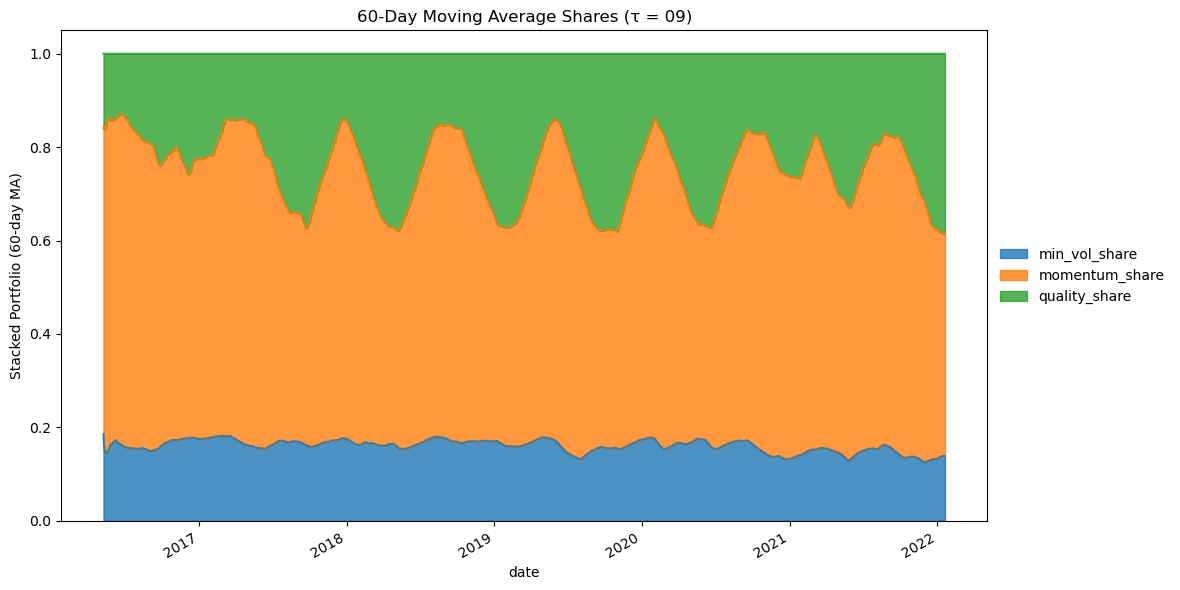

In [21]:
def _plot_smoothed_shares(df, tau_str):
    share_cols = [c for c in df.columns if c.endswith('_share')]
    df_shares = df[['date'] + share_cols].copy()
    df_shares['date'] = pd.to_datetime(df_shares['date'])
    df_shares.set_index('date', inplace=True)

    df_ma = df_shares.rolling(window=60, min_periods=1).mean()

    ax = df_ma.plot(kind='area', stacked=True, figsize=(14, 6), alpha=0.8)
    ax.set_ylabel('Stacked Portfolio (60-day MA)')
    ax.set_title(f'60-Day Moving Average Shares (τ = {tau_str})')

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    filename = f"smoothed_shares_tau_stepwise_{tau_str}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

share_columns = [
    'min_vol_share',
    'momentum_share', 'quality_share'
]

for tau_str in dfs:
    all_seed_dfs = []

    for seed, df in dfs[tau_str].items():
        df = df.copy()
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')
        df = df[['date'] + share_columns]
        all_seed_dfs.append(df)

    combined_df = pd.concat(all_seed_dfs)

    avg_df = combined_df.groupby('date')[share_columns].mean().reset_index()

    _plot_smoothed_shares(avg_df, tau_str)


# Multiple costs

In [19]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import kurtosis, skew
from scipy import stats

import os
# Create a nested dictionary tau-->cost
# NOTE: WE DID THIS ACROSS MANY TRANSACTION COSTS BUT ONE SEED ONLY
tau_levels = [0.1,0.5,0.9]
tau_levels_str = [str(tau).replace('.', '') for tau in tau_levels]
    transaction_cost = ['00001','00005','0001','0002','0005']
#  20250523_stepwisestandardtanh_cost0005_53_09

base_path = "C:/Users/95att/Desktop/job/First_paper_QAC/QAC-Final/QAC-Final/StepWise Learning/StepWiseModel/training_outcome/"
dfs = {}

for tau_str in tau_levels_str:
    dfs[tau_str] = {}
    for cost in transaction_cost:
        folder_name = f"20250523_stepwisestandardtanh_cost{cost}_53_{tau_str}"
        file_path = os.path.join(base_path, folder_name, "train_df_with_shares.csv")

        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            dfs[tau_str][cost] = df
        else:
            print(f" File not found: {file_path}")


In [21]:
#  tau_to_dfs[tau] = [df1, df2, df3...]
tau_to_dfs = {}
for tau, cost_dict in dfs.items():
    for cost, df in cost_dict.items():
        tau_to_dfs.setdefault(tau, []).append(df)

tau_avg_stats = {}
for tau, df_list in tau_to_dfs.items():
    v_columns = [col for col in df_list[0].columns if col.startswith('v_')] # same columns shape
    stacked = np.stack([df[v_columns].values for df in df_list]) # cost, n_steps, n_v_columns
    avg_path = np.mean(stacked, axis=0) # (n_steps, n_v_columns)
    std_path = np.std(stacked, axis=0)

    #tau_avg_paths[tau] = pd.DataFrame(avg_path, columns=v_columns)
    tau_avg_stats[tau] = {
        'mean': pd.DataFrame(avg_path, columns=v_columns),
        'std': pd.DataFrame(std_path, columns=v_columns)
    }



In [44]:
len(tau_to_dfs)

3

In [46]:
len(tau_to_dfs['01'])

5

In [50]:
tau_to_dfs['01'][0]

,date,min_vol,momentum,quality,min_vol_share,momentum_share,quality_share,v_01,v_02,v_03,v_04,v_05,v_06,v_07,v_08,v_09,value_function,absolute_return,cumulative_return
0,2016-05-10,44.78,74.84,66.08,0.428701,0.476404,0.094895,-10.227365,-2.082700,-1.532967,2.036967,2.298139,4.073487,7.286390,8.710213,10.127443,-10.227365,-11.905725,9902.492014
1,2016-05-11,44.41,74.03,65.38,0.618299,0.264402,0.117299,-11.311142,-2.956521,-2.125130,2.074769,2.296542,4.315727,7.771546,9.270056,11.831906,-11.311142,3.397874,9930.049281
2,2016-05-12,44.55,74.21,65.51,0.497947,0.399284,0.102769,-11.163848,-2.976378,-2.170850,1.713350,2.047604,4.803436,7.205695,8.844065,11.520267,-11.163848,-7.931447,9865.545059
3,2016-05-13,44.25,73.80,64.93,0.707618,0.157076,0.135306,-11.482343,-3.147920,-2.251973,2.300528,2.428796,4.079529,7.886493,9.417938,12.100892,-11.482343,10.184876,9947.837732
4,2016-05-16,44.63,74.28,65.55,0.492605,0.388169,0.119226,-11.431615,-2.830533,-2.041734,2.159492,2.343761,4.422637,7.655222,9.344377,11.674834,-11.431615,-16.203310,9815.824711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,2022-01-13,77.91,172.83,139.16,0.780845,0.108550,0.110605,-20.296906,-5.980281,-4.520395,1.748481,3.438216,8.151824,12.216467,15.792576,21.347336,-20.296906,-4.803605,19511.761421
1418,2022-01-14,77.58,172.15,138.91,0.780081,0.109129,0.110790,-20.093777,-5.864272,-4.636327,1.400492,3.325186,8.209870,12.029206,15.613420,21.151010,-20.093777,-15.696982,19260.921324
1419,2022-01-18,76.78,167.68,136.43,0.784357,0.106949,0.108694,-20.129953,-6.296037,-4.707888,1.871901,3.369682,8.061873,12.027305,15.388231,21.401743,-20.129953,-3.826571,19200.558276
1420,2022-01-19,76.69,165.77,135.18,0.785412,0.106618,0.107971,-20.123587,-6.471372,-4.860383,1.773050,3.334734,8.098764,11.923223,15.255022,21.540445,-20.123587,-12.157022,19009.385793


In [5]:
stacked.shape

(5, 1422, 9)

In [7]:
avg_path.shape

(1422, 9)

In [64]:
len(tau_avg_stats['01']['mean'])

1422

In [68]:
tau_avg_stats['01']['std'].columns

Index(['v_01', 'v_02', 'v_03', 'v_04', 'v_05', 'v_06', 'v_07', 'v_08', 'v_09'], dtype='object')

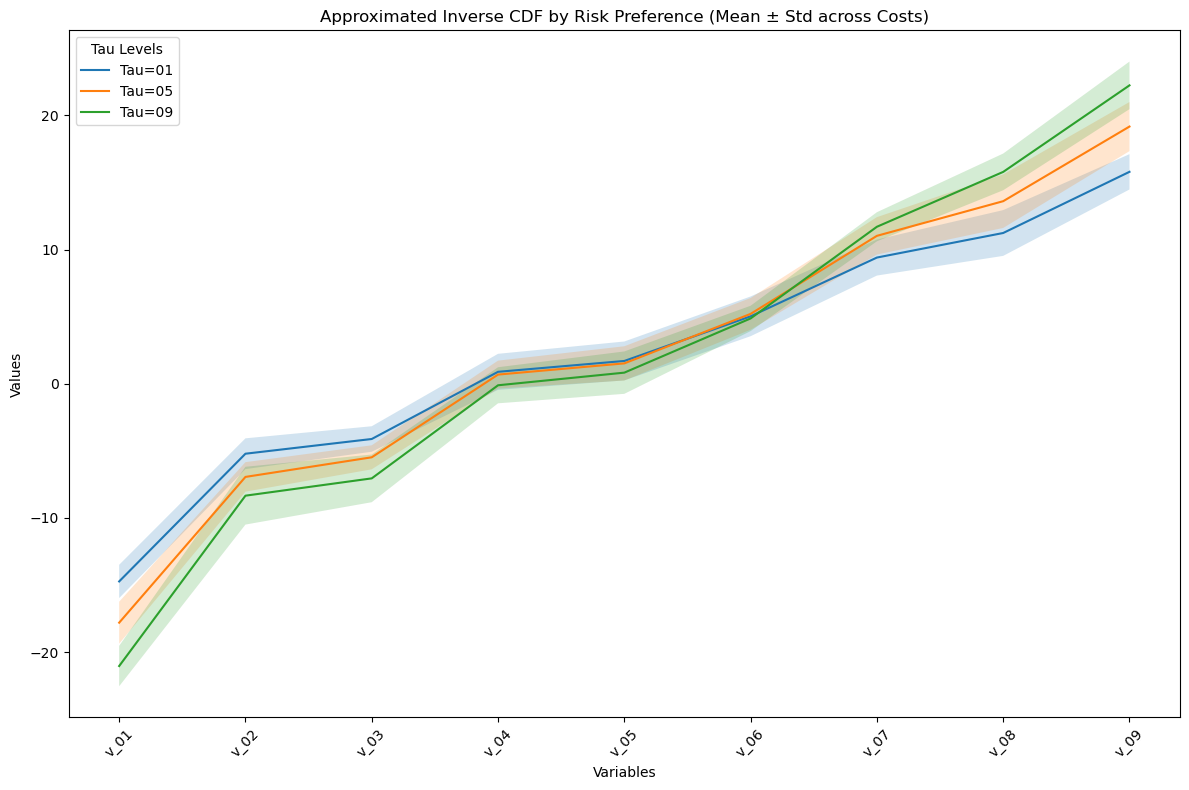

In [35]:
plt.figure(figsize=(12, 8))

for tau, stats in tau_avg_stats.items():
    mean_df = stats['mean']
    std_df = stats['std']
    x = mean_df.columns

    plt.plot(x, mean_df.mean(axis=0), label=f"Tau={tau}")

    plt.fill_between(
        x,
        mean_df.mean(axis=0) - std_df.mean(axis=0),
        mean_df.mean(axis=0) + std_df.mean(axis=0),
        alpha=0.2
    )

plt.xlabel('Variables')
plt.ylabel('Values')
plt.title('Approximated Inverse CDF by Risk Preference (Mean ± Std across Costs)')
plt.legend(title="Tau Levels")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('inverse_cdf_gauss_stepwise_mean_std.png', dpi=300)
plt.show()


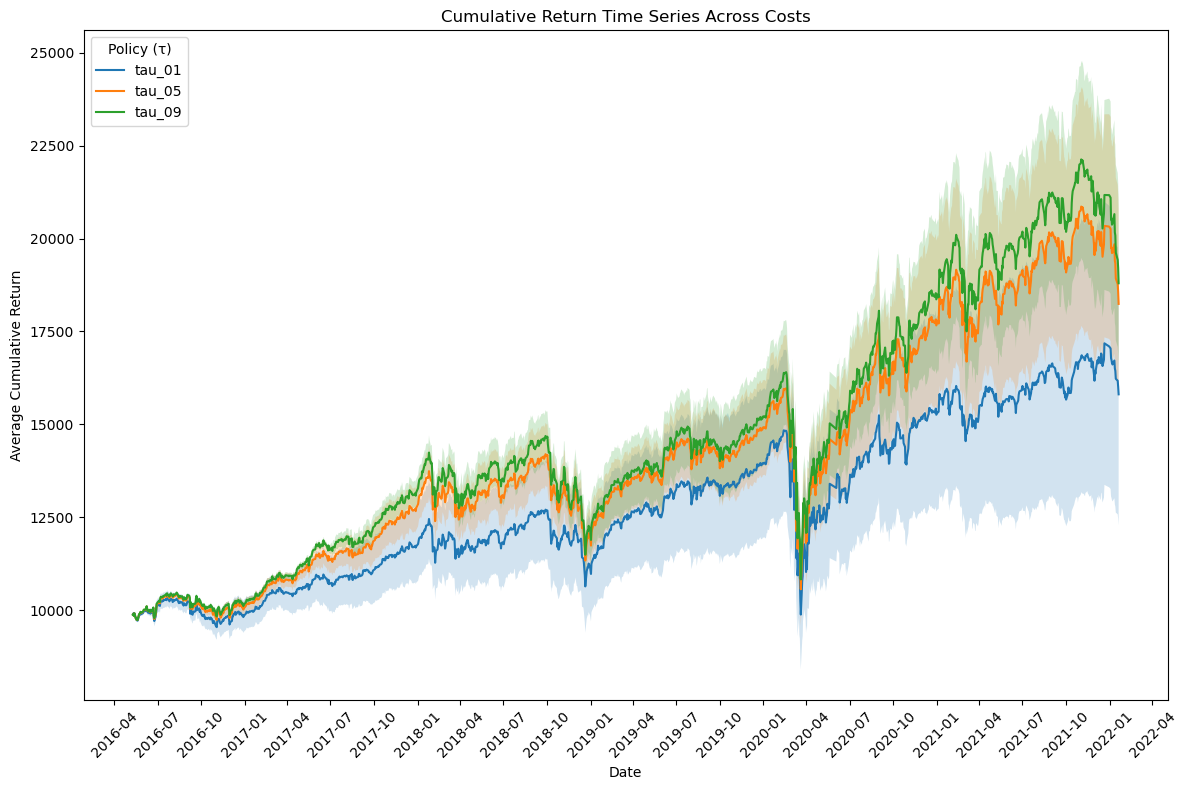

In [37]:

plt.figure(figsize=(12, 8))
ax = plt.gca()

for tau_str in dfs:
    cum_returns_list = []
    date_index = None
    for cost, df in dfs[tau_str].items():
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')
        if date_index is None:
            date_index = df['date'].values
        cum_returns_list.append(df['cumulative_return'].values)

    stacked_returns = np.stack(cum_returns_list)
    avg_cum_return = np.mean(stacked_returns, axis=0)
    std_cum_return = np.std(stacked_returns, axis=0)

    plt.plot(date_index, avg_cum_return, label=f'tau_{tau_str}')
    plt.fill_between(date_index,
                     avg_cum_return - std_cum_return,
                     avg_cum_return + std_cum_return,
                     alpha=0.2)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))     
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))    

plt.xlabel('Date')
plt.ylabel('Average Cumulative Return')
plt.title('Cumulative Return Time Series Across Costs')
plt.legend(title='Policy (τ)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("avg_cumulative_returns_stepwise_with_std.png", dpi=300, bbox_inches='tight')
plt.show()


In [33]:
dfs['01']['0005']

,date,min_vol,momentum,quality,min_vol_share,momentum_share,quality_share,v_01,v_02,v_03,v_04,v_05,v_06,v_07,v_08,v_09,value_function,absolute_return,cumulative_return
0,2016-05-10,44.78,74.84,66.08,0.578057,0.313303,0.108639,-15.272365,-7.596170,-5.837611,-1.793316,-1.202087,2.420115,9.364147,10.415454,15.151738,-15.272365,-14.325694,9882.672445
1,2016-05-11,44.41,74.03,65.38,0.385452,0.491648,0.122901,-14.967089,-7.503458,-6.272779,-1.803657,-1.172812,3.093115,8.501843,9.252029,16.164186,-14.967089,0.901156,9889.966325
2,2016-05-12,44.55,74.21,65.51,0.371362,0.516715,0.111923,-13.730295,-6.983343,-5.822292,-2.023706,-1.228707,2.809138,7.790025,8.454199,14.774782,-13.730295,-8.063314,9824.654368
3,2016-05-13,44.25,73.80,64.93,0.447904,0.377510,0.174586,-14.175621,-7.597251,-6.407649,-1.618322,-0.886175,2.841428,8.106820,8.558784,16.291475,-14.175621,8.019724,9889.184276
4,2016-05-16,44.63,74.28,65.55,0.387238,0.497549,0.115214,-14.099144,-7.471186,-6.030036,-1.579684,-1.115486,2.449071,8.013676,8.507853,15.321419,-14.099144,-17.633779,9746.363892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,2022-01-13,77.91,172.83,139.16,0.751880,0.124868,0.123252,-10.463354,-6.288981,-5.028086,-1.821136,-1.636518,1.226324,3.792089,5.276383,12.224799,-10.463354,-4.995760,9573.497769
1418,2022-01-14,77.58,172.15,138.91,0.756218,0.122249,0.121533,-10.066981,-6.260314,-4.984907,-1.987191,-1.822975,1.035589,3.365661,5.006094,11.827664,-10.066981,-16.099991,9447.262528
1419,2022-01-18,76.78,167.68,136.43,0.713196,0.143241,0.143563,-10.281303,-6.479061,-5.362296,-1.956935,-1.801456,1.330226,3.457474,4.685786,12.575114,-10.281303,-5.162210,9407.320882
1420,2022-01-19,76.69,165.77,135.18,0.675672,0.161511,0.162817,-10.228256,-6.734314,-5.664959,-2.264844,-2.050563,1.170074,3.180237,4.487082,12.845753,-10.228256,-12.987401,9307.258104


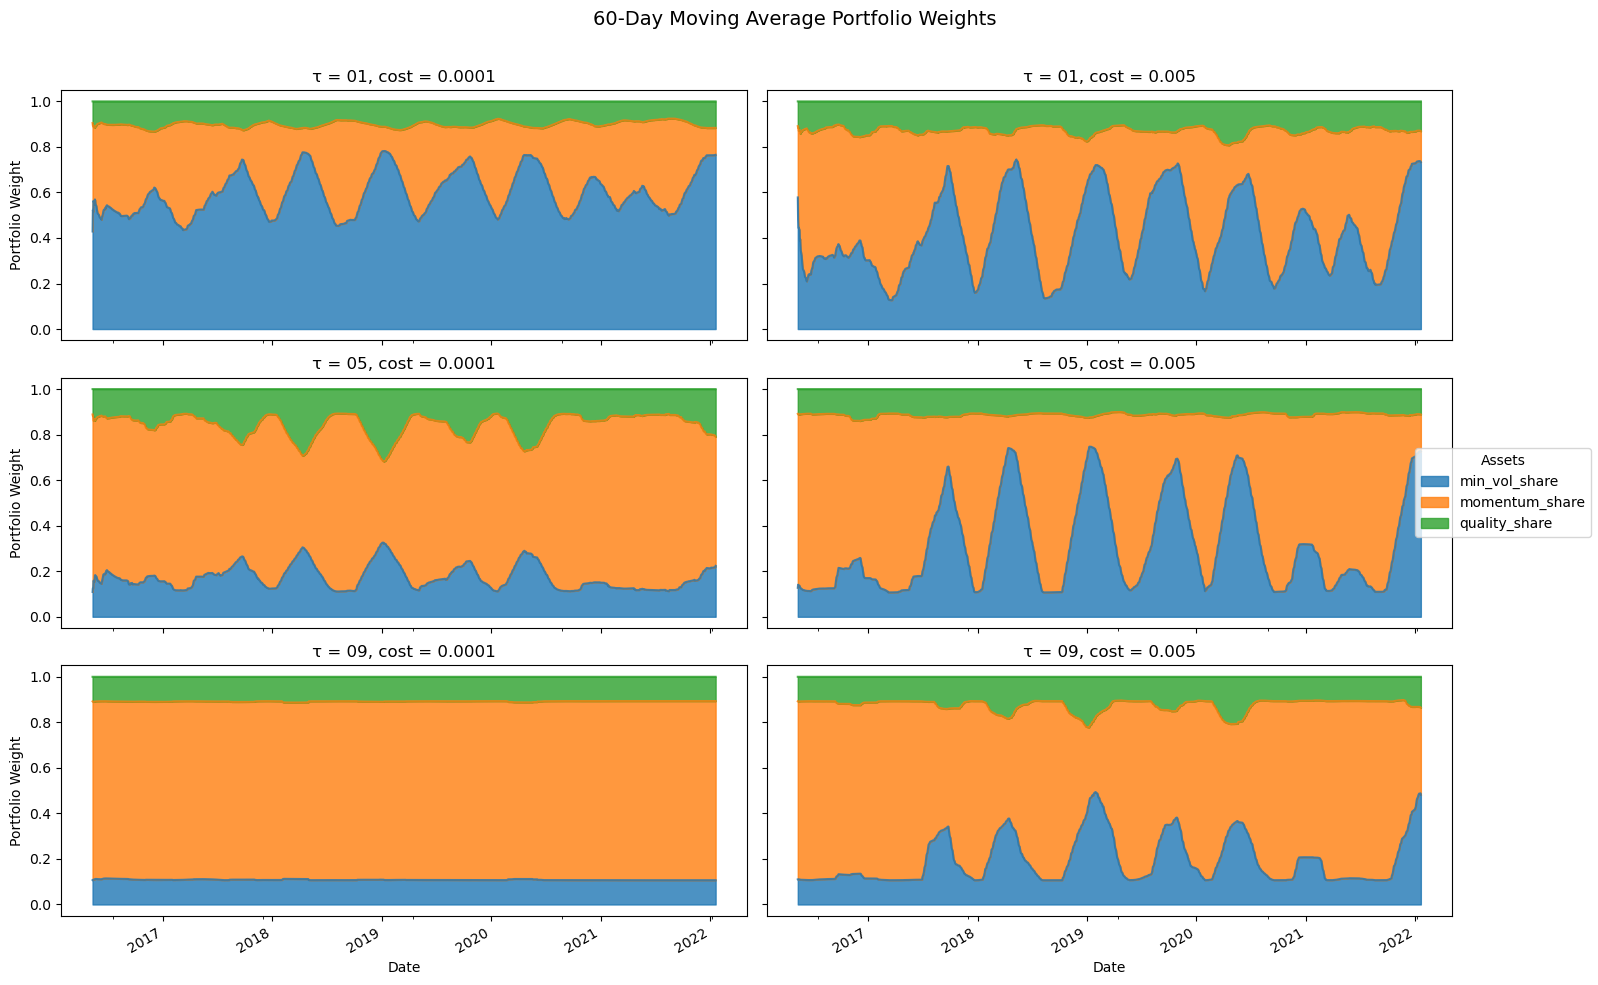

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

share_columns = ['min_vol_share', 'momentum_share', 'quality_share']

def plot_smoothed_shares_grid(dfs, tau_levels_str, share_columns, transaction_cost):
    fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharex=True, sharey=True)
    selected_costs = [transaction_cost[0], transaction_cost[-1]]  # smallest and largest, we had in order before

    for i, tau in enumerate(tau_levels_str):
        for j, cost in enumerate(selected_costs):
            df = dfs[tau][cost].copy()
            df['date'] = pd.to_datetime(df['date'])
            df = df.sort_values('date')
            df.set_index('date', inplace=True)

            df_ma = df[share_columns].rolling(window=60, min_periods=1).mean()
            ax = axes[i, j]
            df_ma.plot(kind='area', stacked=True, alpha=0.8, ax=ax, legend=False)
            formatted_cost = f"0.{cost[1:]}" # adjust back with dot

            ax.set_title(f"τ = {tau}, cost = {formatted_cost}")
            if i == 2:
                ax.set_xlabel("Date")
            if j == 0:
                ax.set_ylabel("Portfolio Weight")

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', title="Assets")
    plt.tight_layout(rect=[0, 0, 0.92, 1])
    plt.suptitle("60-Day Moving Average Portfolio Weights", fontsize=14)
    plt.subplots_adjust(top=0.9)
    plt.savefig("smoothed_shares_cost_grid_stepwise.png", dpi=300)
    plt.show()

plot_smoothed_shares_grid(dfs, tau_levels_str, share_columns, transaction_cost)
